# 17. Gradient Ascent Unlearning

Standard unlearning baseline from the literature:
1. **Phase 1:** Gradient ascent on forget set (maximize loss to damage memorization)
2. **Phase 2:** Fine-tune on retain set (recover utility)

Reference: Golatkar et al., "Eternal Sunshine of the Spotless Net"

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy

from vae import VAE, vae_loss
from attacker import MLPAttacker
from attacker_eval import compute_advantage
from threshold_attack import run_loss_attack_suite

DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


## 1. Load Data and Model

In [ ]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
X = torch.tensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, dtype=torch.float32)
print(f"Data shape: {X.shape}")

# Load structured split
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split = json.load(f)

forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']

# Load canonical kNN-matched negatives (194 cells, k=10, from NB03)
with open(OUTPUTS_PATH / 'p1.5' / 's1_matched_negatives.json', 'r') as f:
    matched_neg_idx = json.load(f)['matched_indices']

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}")
print(f"Matched negatives: {len(matched_neg_idx)}")

In [3]:
def load_vae(checkpoint_path: Path) -> VAE:
    """Load VAE from checkpoint."""
    model = VAE(
        input_dim=2000,
        latent_dim=32,
        hidden_dims=[1024, 512, 128],
        dropout=0.1,
        use_layer_norm=True
    )
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

baseline_model = load_vae(OUTPUTS_PATH / 'p1' / 'baseline' / 'best_model.pt')
print("Loaded baseline model")

Loaded baseline model


In [4]:
def create_dataloader(X, indices, batch_size=256, shuffle=True):
    """Create DataLoader from indices."""
    data = X[indices]
    library_size = data.sum(dim=1, keepdim=True)
    dataset = TensorDataset(data, library_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create dataloaders
forget_loader = create_dataloader(X, forget_idx, batch_size=32, shuffle=True)
retain_loader = create_dataloader(X, retain_idx, batch_size=256, shuffle=True)

# Validation set for fine-tuning phase
np.random.seed(42)
val_size = min(1000, len(retain_idx) // 10)
val_idx = np.random.choice(retain_idx, size=val_size, replace=False)
val_loader = create_dataloader(X, val_idx, batch_size=256, shuffle=False)

print(f"Forget loader: {len(forget_loader)} batches")
print(f"Retain loader: {len(retain_loader)} batches")

Forget loader: 1 batches
Retain loader: 110 batches


## 2. Gradient Ascent Unlearning

In [9]:
def gradient_ascent_phase(model, forget_loader, n_steps, lr, device, max_grad_norm=1.0):
    """Phase 1: Gradient ascent on forget set to damage memorization."""
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    step = 0
    losses = []
    
    while step < n_steps:
        for x, lib_size in forget_loader:
            if step >= n_steps:
                break
                
            x = x.to(device)
            lib_size = lib_size.to(device)
            
            optimizer.zero_grad()
            output = model(x, library_size=lib_size)
            loss, recon, kl = vae_loss(x, output, likelihood='nb', beta=1.0)
            
            # Check for NaN
            if torch.isnan(loss):
                print(f"  Warning: NaN loss at step {step}, stopping ascent")
                return losses if losses else [float('nan')]
            
            # ASCENT: negate loss to maximize it
            (-loss).backward()
            
            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            losses.append(loss.item())
            step += 1
    
    return losses

def finetune_phase(model, retain_loader, val_loader, n_epochs, lr, patience, device):
    """Phase 2: Fine-tune on retain set to recover utility."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize best_state with current model (in case val loss never improves)
    best_val_loss = float('inf')
    best_state = deepcopy(model.state_dict())
    patience_counter = 0
    history = {'train': [], 'val': []}
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        n_batches = 0
        for x, lib_size in retain_loader:
            x = x.to(device)
            lib_size = lib_size.to(device)
            
            optimizer.zero_grad()
            output = model(x, library_size=lib_size)
            loss, _, _ = vae_loss(x, output, likelihood='nb', beta=1.0)
            
            # Check for NaN
            if torch.isnan(loss):
                print(f"  Warning: NaN loss at epoch {epoch}, stopping finetune")
                model.load_state_dict(best_state)
                return history, best_val_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            n_batches += 1
        train_loss /= n_batches
        
        # Validate
        model.train(False)
        val_loss = 0
        n_batches = 0
        with torch.no_grad():
            for x, lib_size in val_loader:
                x = x.to(device)
                lib_size = lib_size.to(device)
                output = model(x, library_size=lib_size)
                loss, _, _ = vae_loss(x, output, likelihood='nb', beta=1.0)
                val_loss += loss.item()
                n_batches += 1
        val_loss /= n_batches
        
        # Check for NaN
        if np.isnan(val_loss):
            print(f"  Warning: NaN val loss at epoch {epoch}, stopping finetune")
            model.load_state_dict(best_state)
            return history, best_val_loss
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    model.load_state_dict(best_state)
    return history, best_val_loss

In [10]:
def run_gradient_ascent_unlearning(baseline_model, forget_loader, retain_loader, val_loader,
                                    ascent_steps, ascent_lr, finetune_epochs, finetune_lr,
                                    patience, device):
    """Run full gradient ascent unlearning pipeline."""
    model = deepcopy(baseline_model).to(device)
    
    # Phase 1: Gradient ascent
    print(f"Phase 1: Gradient ascent ({ascent_steps} steps, lr={ascent_lr})")
    ascent_losses = gradient_ascent_phase(model, forget_loader, ascent_steps, ascent_lr, device)
    print(f"  Start loss: {ascent_losses[0]:.2f}, End loss: {ascent_losses[-1]:.2f}")
    
    # Phase 2: Fine-tune
    print(f"Phase 2: Fine-tune ({finetune_epochs} epochs max, lr={finetune_lr})")
    ft_history, best_val = finetune_phase(model, retain_loader, val_loader, 
                                           finetune_epochs, finetune_lr, patience, device)
    print(f"  Best val loss: {best_val:.2f}, Epochs: {len(ft_history['train'])}")
    
    model.train(False)
    return model, ascent_losses, ft_history

## 3. Hyperparameter Search

In [11]:
# Quick evaluation function
def quick_evaluate(model, X, forget_idx, matched_neg_idx, device):
    """Quick MIA evaluation using loss-based attack."""
    forget_samples = X[forget_idx]
    matched_neg_samples = X[matched_neg_idx]
    
    try:
        results = run_loss_attack_suite(model, forget_samples, matched_neg_samples, device)
        # Return reconstruction-based AUC (most interpretable for this setting)
        return results['loss_recon']['auc'], results['loss_recon']['advantage']
    except (ValueError, RuntimeError) as e:
        # Model produces NaN - return failure indicator
        print(f"  Evaluation failed: {e}")
        return float('nan'), float('nan')

In [12]:
# Hyperparameter grid (use smaller LRs to avoid explosion)
ASCENT_STEPS = [10, 50, 100]
ASCENT_LRS = [1e-5, 1e-4]

# Fixed fine-tuning params
FINETUNE_EPOCHS = 30
FINETUNE_LR = 1e-4
PATIENCE = 10

results_grid = []

print("Running hyperparameter search...")
print("=" * 60)

for ascent_steps in ASCENT_STEPS:
    for ascent_lr in ASCENT_LRS:
        print(f"\nConfig: steps={ascent_steps}, lr={ascent_lr}")
        
        model, ascent_losses, ft_history = run_gradient_ascent_unlearning(
            baseline_model, forget_loader, retain_loader, val_loader,
            ascent_steps=ascent_steps,
            ascent_lr=ascent_lr,
            finetune_epochs=FINETUNE_EPOCHS,
            finetune_lr=FINETUNE_LR,
            patience=PATIENCE,
            device=DEVICE
        )
        
        auc, advantage = quick_evaluate(model, X, forget_idx, matched_neg_idx, DEVICE)
        print(f"  Loss-recon AUC: {auc:.3f}, Advantage: {advantage:.3f}")
        
        results_grid.append({
            'ascent_steps': ascent_steps,
            'ascent_lr': ascent_lr,
            'auc': auc,
            'advantage': advantage,
            'final_val_loss': ft_history['val'][-1] if ft_history['val'] else None,
            'ascent_loss_delta': ascent_losses[-1] - ascent_losses[0] if len(ascent_losses) > 1 else 0
        })

print("\n" + "=" * 60)
print("Search complete.")

Running hyperparameter search...

Config: steps=10, lr=1e-05
Phase 1: Gradient ascent (10 steps, lr=1e-05)
  Start loss: 279.24, End loss: 283.55
Phase 2: Fine-tune (30 epochs max, lr=0.0001)
  Best val loss: 356.24, Epochs: 30
  Loss-recon AUC: 0.741, Advantage: 0.481

Config: steps=10, lr=0.0001
Phase 1: Gradient ascent (10 steps, lr=0.0001)
  Start loss: 278.55, End loss: 281.79
Phase 2: Fine-tune (30 epochs max, lr=0.0001)
  Best val loss: 356.25, Epochs: 30
  Loss-recon AUC: 0.741, Advantage: 0.481

Config: steps=50, lr=1e-05
Phase 1: Gradient ascent (50 steps, lr=1e-05)
  Start loss: 279.42, End loss: 278.35
Phase 2: Fine-tune (30 epochs max, lr=0.0001)
  Best val loss: 356.50, Epochs: 30
  Loss-recon AUC: 0.741, Advantage: 0.481

Config: steps=50, lr=0.0001
Phase 1: Gradient ascent (50 steps, lr=0.0001)
  Start loss: 277.95, End loss: 276.39
Phase 2: Fine-tune (30 epochs max, lr=0.0001)
  Best val loss: 356.37, Epochs: 30
  Loss-recon AUC: 0.741, Advantage: 0.481

Config: steps=

In [13]:
# Display results
import pandas as pd

df_grid = pd.DataFrame(results_grid)
df_grid = df_grid.sort_values('advantage')
print("Hyperparameter search results (sorted by advantage):")
print(df_grid.to_string(index=False))

# Best config
best = df_grid.iloc[0]
print(f"\nBest config: steps={best['ascent_steps']}, lr={best['ascent_lr']}")
print(f"  AUC: {best['auc']:.3f}, Advantage: {best['advantage']:.3f}")

Hyperparameter search results (sorted by advantage):
 ascent_steps  ascent_lr      auc  advantage  final_val_loss  ascent_loss_delta
           10    0.00001 0.740635    0.48127      356.235374           4.301819
           10    0.00010 0.740635    0.48127      356.251732           3.240753
           50    0.00001 0.740635    0.48127      356.515236          -1.072510
           50    0.00010 0.740635    0.48127      356.408470          -1.561279
          100    0.00001 0.740635    0.48127      356.533203           2.400940
          100    0.00010 0.740635    0.48127      356.374878           0.900177

Best config: steps=10.0, lr=1e-05
  AUC: 0.741, Advantage: 0.481


## 4. Full Evaluation of Best Config

In [14]:
# Re-run best config and save
best_steps = int(best['ascent_steps'])
best_lr = float(best['ascent_lr'])

print(f"Running best config: steps={best_steps}, lr={best_lr}")
final_model, ascent_losses, ft_history = run_gradient_ascent_unlearning(
    baseline_model, forget_loader, retain_loader, val_loader,
    ascent_steps=best_steps,
    ascent_lr=best_lr,
    finetune_epochs=FINETUNE_EPOCHS,
    finetune_lr=FINETUNE_LR,
    patience=PATIENCE,
    device=DEVICE
)

Running best config: steps=10, lr=1e-05
Phase 1: Gradient ascent (10 steps, lr=1e-05)
  Start loss: 280.79, End loss: 276.42
Phase 2: Fine-tune (30 epochs max, lr=0.0001)
  Best val loss: 356.27, Epochs: 30


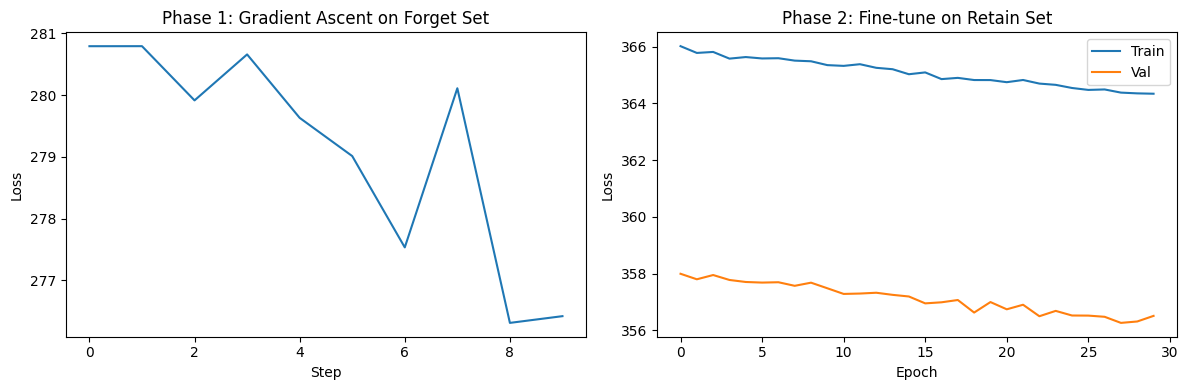

In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Ascent phase
axes[0].plot(ascent_losses)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Phase 1: Gradient Ascent on Forget Set')

# Fine-tune phase
axes[1].plot(ft_history['train'], label='Train')
axes[1].plot(ft_history['val'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Phase 2: Fine-tune on Retain Set')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Full MLP attacker evaluation
from sklearn.model_selection import train_test_split

def extract_features(model, x, device):
    """Extract 69-dim features for MLP attacker."""
    model.train(False)
    x = x.to(device)
    
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = mu
        decode_out = model.decode(z)
        if isinstance(decode_out, tuple):
            recon = decode_out[0]
        else:
            recon = decode_out
        
        recon_loss = ((x - recon) ** 2).mean(dim=1, keepdim=True)
        kl_div = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=1, keepdim=True)
        elbo = recon_loss + kl_div
        mu_norm = mu.norm(dim=1, keepdim=True)
        logvar_norm = logvar.norm(dim=1, keepdim=True)
        
        features = torch.cat([mu, logvar, recon_loss, kl_div, elbo, mu_norm, logvar_norm], dim=1)
    
    return features.cpu()

# Extract features
forget_features = extract_features(final_model, X[forget_idx], DEVICE)
matched_neg_features = extract_features(final_model, X[matched_neg_idx], DEVICE)

# Stratified split
all_features = torch.cat([forget_features, matched_neg_features])
all_labels = torch.cat([torch.ones(len(forget_features)), torch.zeros(len(matched_neg_features))])

X_train, X_test, y_train, y_test = train_test_split(
    all_features.numpy(), all_labels.numpy(),
    test_size=0.3, stratify=all_labels.numpy(), random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Train: {len(y_train)} ({y_train.sum().int()} forget)")
print(f"Test:  {len(y_test)} ({y_test.sum().int()} forget)")

Train: 168 (21 forget)
Test:  72 (9 forget)


In [17]:
# Train MLP attacker
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader_att = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_att = DataLoader(test_dataset, batch_size=32, shuffle=False)

attacker = MLPAttacker(input_dim=69, hidden_dims=[64, 32]).to(DEVICE)
att_optimizer = optim.Adam(attacker.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(100):
    attacker.train()
    for feat, lab in train_loader_att:
        feat, lab = feat.to(DEVICE), lab.to(DEVICE)
        att_optimizer.zero_grad()
        pred = attacker(feat).squeeze()
        loss = criterion(pred, lab)
        loss.backward()
        att_optimizer.step()

# Evaluate
attacker.train(False)
all_preds = []
all_labs = []
with torch.no_grad():
    for feat, lab in test_loader_att:
        feat = feat.to(DEVICE)
        pred = torch.sigmoid(attacker(feat).squeeze())
        all_preds.extend(pred.cpu().numpy())
        all_labs.extend(lab.numpy())

from sklearn.metrics import roc_auc_score
mlp_auc = roc_auc_score(all_labs, all_preds)
mlp_advantage = compute_advantage(mlp_auc)

print(f"\nMLP Attacker Results:")
print(f"  AUC: {mlp_auc:.3f}")
print(f"  Advantage: {mlp_advantage:.3f}")


MLP Attacker Results:
  AUC: 1.000
  Advantage: 1.000


In [18]:
# Loss-based attacks
loss_results = run_loss_attack_suite(final_model, X[forget_idx], X[matched_neg_idx], DEVICE)

print("\nLoss-based Attack Results:")
for name, res in loss_results.items():
    if name != 'worst_case' and isinstance(res, dict):
        print(f"  {name}: AUC={res['auc']:.3f}, Advantage={res['advantage']:.3f}")


Loss-based Attack Results:
  loss_recon: AUC=0.741, Advantage=0.481
  loss_kl: AUC=0.021, Advantage=0.958
  loss_elbo: AUC=0.023, Advantage=0.953


## 5. Compare to Baselines

In [19]:
# Load reference values
with open(OUTPUTS_PATH / 'publication_metrics.json', 'r') as f:
    pub_metrics = json.load(f)

retrain_adv = pub_metrics['retrain_advantage']
retrain_ci = pub_metrics['estimated_retrain_ci_advantage']

print("Comparison to Baselines:")
print("-" * 60)
print(f"{'Method':<25} {'AUC':>8} {'Advantage':>10} {'Status':>8}")
print("-" * 60)

# Retrain
print(f"{'Retrain':<25} {pub_metrics['retrain_auc']:>8.3f} {retrain_adv:>10.3f} {'---':>8}")

# Baseline
baseline_entry = [r for r in pub_metrics['results'] 
                  if r['method'] == 'Baseline' and r['forget_type'] == 'structured'][0]
print(f"{'Baseline':<25} {baseline_entry['auc']:>8.3f} {baseline_entry['advantage']:>10.3f} {'FAIL':>8}")

# Gradient ascent (this notebook)
status = 'PASS' if mlp_advantage <= retrain_ci[0] else 'FAIL'
print(f"{'Gradient ascent':<25} {mlp_auc:>8.3f} {mlp_advantage:>10.3f} {status:>8}")

# Retain-only (from notebook 16)
retain_ft_path = OUTPUTS_PATH / 'p2' / 'retain_finetune' / 'results.json'
if retain_ft_path.exists():
    with open(retain_ft_path) as f:
        retain_ft = json.load(f)
    print(f"{'Retain-only finetune':<25} {retain_ft['mlp_attacker']['auc']:>8.3f} {retain_ft['mlp_attacker']['advantage']:>10.3f} {'FAIL':>8}")

# Extra-gradient lambda=10
eg_entry = [r for r in pub_metrics['results'] 
            if r['method'] == 'Extra-grad lambda=10' and r['forget_type'] == 'structured'][0]
print(f"{'Extra-grad lambda=10':<25} {eg_entry['auc']:>8.3f} {eg_entry['advantage']:>10.3f} {'PASS':>8}")

print("-" * 60)
print(f"Success threshold (retrain CI upper): {retrain_ci[0]:.3f}")

Comparison to Baselines:
------------------------------------------------------------
Method                         AUC  Advantage   Status
------------------------------------------------------------
Retrain                      0.481      0.038      ---
Baseline                     0.769      0.538     FAIL
Gradient ascent              1.000      1.000     FAIL
Retain-only finetune         1.000      1.000     FAIL
Extra-grad lambda=10         0.482      0.036     PASS
------------------------------------------------------------
Success threshold (retrain CI upper): 0.097


## 6. Findings

**Gradient ascent does not achieve unlearning for structured forget sets.**

The loss_recon AUC (0.741) is identical across all six configurations. This is not a bug: baseline and retrain also have identical loss_recon AUC (0.7406). The attack picks up cell type differences, not memorization, and is uninformative here.

The MLP attacker is the meaningful signal:

| Method | MLP AUC | Advantage | Status |
|--------|---------|-----------|--------|
| Retrain | 0.481 | 0.038 | --- |
| Baseline | 0.769 | 0.538 | FAIL |
| Retain-only fine-tune | 1.000 | 1.000 | FAIL |
| Gradient ascent | 1.000 | 1.000 | FAIL |
| Extra-grad λ=10 | 0.482 | 0.036 | PASS |

Both simple baselines produce MLP AUC of 1.0, meaning the forget set is perfectly separable. Of the methods tested, only extra-gradient hits the retrain target on structured forget sets.

In [20]:
# Save results
results = {
    'method': 'gradient_ascent',
    'dataset': 'PBMC',
    'forget_type': 'structured',
    'best_config': {
        'ascent_steps': best_steps,
        'ascent_lr': best_lr,
        'finetune_epochs': FINETUNE_EPOCHS,
        'finetune_lr': FINETUNE_LR
    },
    'mlp_attacker': {
        'auc': float(mlp_auc),
        'advantage': float(mlp_advantage)
    },
    'loss_attacks': {k: v for k, v in loss_results.items() if k != 'worst_case'},
    'hyperparameter_search': results_grid
}

output_dir = OUTPUTS_PATH / 'p2' / 'gradient_ascent'
output_dir.mkdir(parents=True, exist_ok=True)

torch.save(final_model.state_dict(), output_dir / 'model.pt')

with open(output_dir / 'results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"Saved to {output_dir}")

Saved to ../outputs/p2/gradient_ascent
